# Analyse FEP outputs

In [1]:
# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, './freenrgworkflows/networkanalysis/')

import networkanalysis
import experiments
import stats

# import some other modules that we'll need.
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd 
from rdkit import Chem


#### In this notebook we will analyse FEP output generated by BioSimSpace on a computing cluster. The files required for this are written by BSS as 'summary.csv' in the execution model.

The matplotlib.pyplot code in this notebook has been left in a single-use (i.e. not wrapped in functions etc) on purpose because it is expected that users will customise plotting code extensively. Therefore, the plotting code presented should be treated mostly as an example as there are many ways to improve upon it. For a good overview of FEP data reporting best practices, see section 8.7 in https://www.livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378/963.

## 1. Load FEP output data.

### Variables

In [2]:
# a CSV file output by SOMD that contains perturbation name,free energy,confidence.
results_filepath = 'outputs/fep_outputs/summary_august_somd_run1_i.csv'

# experimental values (e.g. ic50/ki) for all ligands in our set. This is optional.
exp_filepath = 'inputs/exp_data_tyk2.dat'

# if we have added any intermediate ligands, define the regular expression here. Ligands 
# containing this pattern will be excluded from calculations that compare to experimental values.
intermediate_string = 'intermediate_01' # if you want to exclude an intermediate, just input as string.

Now that we have run all our simulations (which should have appended results to a file - in our case "summary...csv"), we can start analysing our results. Additionally, we would like to compare our predictions to experimental measures.

We use FreeNrgWorkFlows (https://github.com/michellab/freenrgworkflows) to analyse our predictions. Instead of just computing $\Delta\Delta$G values for each transformation, we would like to estimate the $\Delta\Delta$G value for each individual ligand. There are some involved algorithms needed for these steps which is what FreeNrgWorkFlows takes care of for us.

In [3]:
nA = networkanalysis.NetworkAnalyser()
nA.read_perturbations_pandas(results_filepath, comments='#')

In [4]:
# add more replicates to the graph. FreeNrgWorkflows will take care of averaging 
# the free energies as well as propagating the error.
nA.add_data_to_graph_pandas("outputs/fep_outputs/summary_august_somd_run2_i.csv")
nA.add_data_to_graph_pandas("outputs/fep_outputs/summary_august_somd_run3_i.csv")
nA.add_data_to_graph_pandas("outputs/fep_outputs/summary_august_somd_run4_i.csv")
nA.add_data_to_graph_pandas("outputs/fep_outputs/summary_august_somd_run5_i.csv")
computed_relative_DDGs = nA.freeEnergyInKcal
computed_relative_DDGs

Added additional data to 46 edges; added 0 new edges.
Added additional data to 46 edges; added 0 new edges.
Added additional data to 46 edges; added 0 new edges.
Added additional data to 46 edges; added 0 new edges.


[{'ejm_31': 1.1807985455425216, 'error': 0.5196363484258372},
 {'ejm_42': 0.5591453742087983, 'error': 0.5671051442810263},
 {'ejm_43': 0.4753330348627717, 'error': 0.8104370073798862},
 {'ejm_44': 2.482806454089421, 'error': 0.7627548427762768},
 {'ejm_45': 2.641534802046952, 'error': 0.8289698872317532},
 {'ejm_46': -1.174237661251835, 'error': 0.49958751204047164},
 {'ejm_47': 0.34333294296608474, 'error': 0.3451683005997491},
 {'ejm_48': -1.4271626612518353, 'error': 0.7540682440592277},
 {'ejm_49': -0.04236266125183552, 'error': 0.5755256965937339},
 {'ejm_50': 0.6963363081983671, 'error': 0.487356953093133},
 {'ejm_54': -1.0375771213010692, 'error': 0.5690589773612498},
 {'ejm_55': -0.6506646021823619, 'error': 0.3647104133587623},
 {'intermediate_01': 0.6601623387481644, 'error': 0.4314324958294327},
 {'jmc_23': -1.5272042241750954, 'error': 0.7008648241822781},
 {'jmc_27': -1.3125197531982777, 'error': 0.5856616867917471},
 {'jmc_28': -0.8238475264864167, 'error': 0.93495074949

## 2. Load experimental data (if available) and compile into pandas.
In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data. Using Pandas, we can work with our data in an intuitive way that is easy to use for plotting graphs.

Load the experimental data. 

In [5]:
experiments = experiments.ExperimentalData()

experiments.compute_affinities(exp_filepath, data_type="IC50", comments="#", delimiter=",")
experimental_DDGs = experiments.freeEnergiesInKcal

For plotting it is typically easier to work with the pandas library. This next bit of code reshapes the data into a dataframe format. 

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input.

In [6]:
freenrg_dict = {}

# construct dict with experimental freenrg and error.
for item in experimental_DDGs:
    ligand = list(item.keys())[0]
    freenrg = list(item.values())[0]
    error = list(item.values())[1]
    freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
        
        
        if intermediate_string not in ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("outputs/fep_results_table.csv")



## 3. Plot data with statistics.
There are several ways to plot FEP results comparing them to experimental data. In this tutorial, we will use matplotlib and seaborn to plot a bargraph and a scatterplot, while also depicting statistics with confidence bounds. Combining these should give a good indication of whether our FEP method is able to predict reliably.

NB: even though we depict per-ligand binding affinities as $\Delta$G, strictly speaking these are still quantities of $\Delta\Delta$G because they are still relative binding free energies compared to a reference! The $\Delta$G notation in this way is just a commonly applied tactic to indicate that the plots are per-ligand instead of pairwise.

### 3.1. Barplot

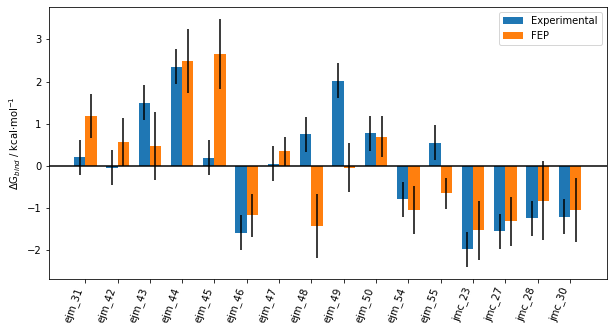

In [7]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("outputs/fep_vs_exp_barplot.png", dpi=300)
plt.show()

### 3.2. Scatterplot

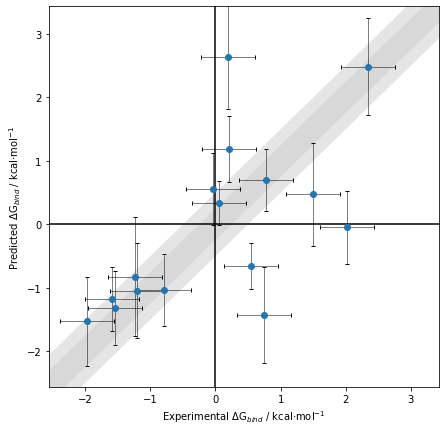

In [8]:
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("outputs/fep_vs_exp_scatterplot.png", dpi=300)
#plt.show()

### 3.3. Statistical analysis.
Error analysis on typical statistical measures: R, Mean Unsigned/Absolute Error (MUE) and Kendall Tau.

Below are examples of how to re-sample from the data in order to obtain error bars on correlation coefficients,
MUE and Kendall tau. Returned are confidence intervals of 65% and the median of the distribution. It is important to take these confidences into account as FEP predictions have a variance associated with them.

In [9]:
_stats = stats.freeEnergyStats()
_stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
r_confidence = _stats.R_confidence
tau_confidence = _stats.tau_confidence
mue_confidence = _stats.mue_confidence
print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

R confidence is:   0.53 < 0.57 < 0.62
MUE confidence is: 0.92 < 0.98 < 1.04
Tau confidence is: 0.37 < 0.42 < 0.45


## 4. Final notes

#### An example custom plot: outlier annotation.
Using some code to determine which data points to annotate, we can display their names on the scatter plot:

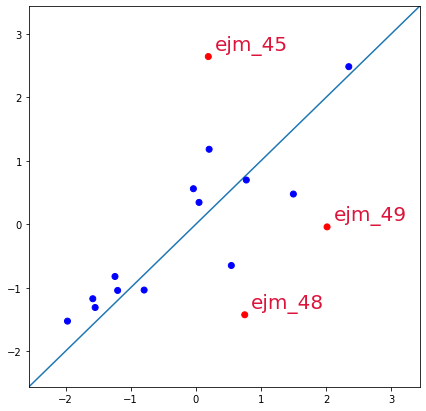

In [10]:
number_outliers_to_annotate = 3

# get an array of the MUE values comparing experimental and FEP values. Take the absolute values.
mue_values = abs(freenrg_df["freenrg_exp"] - freenrg_df["freenrg_fep"])

# find the n ligand names that are outliers.
outlier_names = mue_values.nlargest(number_outliers_to_annotate).index.values.tolist()

# construct a list of labels to annotate the scatterplot with.
annot_labels = []
colours = []
for ligand in freenrg_df.index.values:
    # if the ligand is an outlier, append the name to the annotation labels list.
    if ligand in outlier_names:
        annot_labels.append(ligand)
        colours.append("red")
    else:
        # if the ligand is not an outlier, append an empty string to the annotation labels list.
        annot_labels.append("")
        colours.append("blue")

# Create the same scatterplot as above. Can include some more of the formatting if needed.
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10, c=colours)
plt.plot((-10,10),(-10,10))
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

# then, after generating the figure, we can annotate:
for i, txt in enumerate(annot_labels):
    plt.annotate(txt, 
                 (freenrg_df["freenrg_exp"].values.tolist()[i]+0.1,     # x coords
                  freenrg_df["freenrg_fep"].values.tolist()[i]+0.1),    # y coords
                 size=20, color="crimson")

This kind of analysis is helpful to see what types of R groups will be unreliable in future FEP runs for this series. In our case, the outliers have cyclical R groups: this makes sense as growing/vanishing cyclic structures is notoriously difficult in FEP.

#### In case of no experimental measures, just plot the FEP predictions

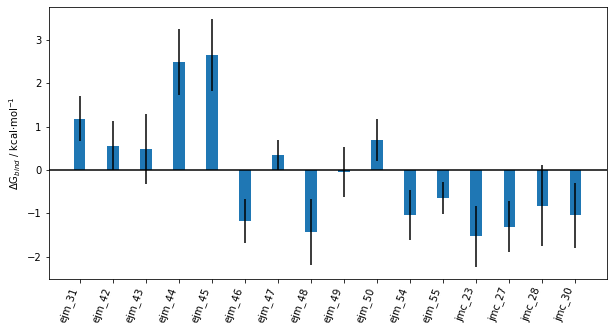

In [11]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our FEP energies.
ax.bar(x_locs, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"])

# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")

plt.savefig("outputs/fep_barplot.png", dpi=300)
plt.show()

Or just create a table with the results. 

In [12]:
results_table = pd.DataFrame(freenrg_df["freenrg_fep"]).sort_values(by="freenrg_fep")

# we can write the table to a csv file that can be opened in e.g. Excel.
results_table.to_csv("outputs/fep_predictions.csv")

results_table

,freenrg_fep
jmc_23,-1.527204
ejm_48,-1.427163
jmc_27,-1.312520
ejm_46,-1.174238
jmc_30,-1.043874
ejm_54,-1.037577
jmc_28,-0.823848
ejm_55,-0.650665
ejm_49,-0.042363
ejm_47,0.343333


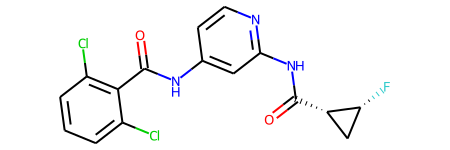

In [13]:
# let's see what molecule FEP has predicted to have the highest binding affinity to our target.
top_ligand = Chem.MolFromMol2File("inputs/ligands/jmc_23.mol2")
Chem.rdDepictor.Compute2DCoords(top_ligand) # removes the pose from the ligand for easier viewing.
top_ligand

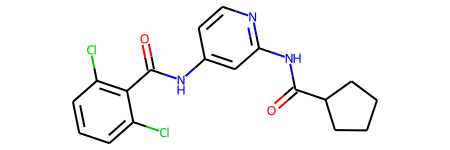

In [14]:
# let's see what molecule FEP has predicted to have the second highest binding affinity to our target.
top_ligand = Chem.MolFromMol2File("inputs/ligands/ejm_48.mol2")
Chem.rdDepictor.Compute2DCoords(top_ligand) # removes the pose from the ligand for easier viewing.
top_ligand